# Trabalho Final de Mineração de Dados

## Importando bibliotecas

In [1]:
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from collections import Counter
import pandas as pd
import numpy as np
import nltk
import string
nltk.download("punkt")
nltk.download("stopwords")

C:\Users\demet\AppData\Roaming\Python\Python39\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\demet\AppData\Roaming\Python\Python39\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\demet\AppData\Roaming\Python\Python39\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\demet\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\demet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1 - Fase de Preparação dos Dados
---

Carregando o arquivo original de classes.

In [2]:
classes_original = pd.read_excel("dados/SistemaDeClassificacao.xlsx", "Select viw_classificacao_arvore")
classes_original.head()

,,COD_CLASSE,DES_NOME_PREFERIDO,COD_CLASSE_PAI,NUM_NIVEL,CYCLE,TREE,PATH,QTD_FILHOS,DES_NIVEL1,DES_NIVEL2,DES_NIVEL3,DES_NIVEL4
0,1,33254494,Classificação Temática Unificada,NaN,1,0,Classificação Temática Unificada,Classificação Temática Unificada,202,NaN,NaN,NaN,NaN
1,2,33809814,Temas Exclusivos de Pronunciamentos,33254494.0,2,0,-- Temas Exclusivos de Pronunciamentos,Classificação Temática Unificada / Temas Exclu...,22,Temas Exclusivos de Pronunciamentos,NaN,NaN,NaN
2,3,33809634,Meio Ambiente,33254494.0,2,0,-- Meio Ambiente,Classificação Temática Unificada / Meio Ambiente,11,Meio Ambiente,NaN,NaN,NaN
3,4,33809514,"Soberania, Defesa Nacional e Ordem Pública",33254494.0,2,0,"-- Soberania, Defesa Nacional e Ordem Pública","Classificação Temática Unificada / Soberania, ...",7,"Soberania, Defesa Nacional e Ordem Pública",NaN,NaN,NaN
4,5,33808912,Política Social,33254494.0,2,0,-- Política Social,Classificação Temática Unificada / Política So...,37,Política Social,NaN,NaN,NaN


Filtra o arquivo de classes original para exibir apenas aquelas que serão raiz na classificação da ementa.
Essa classes possuem nível 2 na tabela original.

In [3]:
classes_raiz = classes_original.query("NUM_NIVEL == 2").filter(["COD_CLASSE", "DES_NOME_PREFERIDO"])
classes_raiz.rename(columns={"DES_NOME_PREFERIDO": "DES_CLASSE"}, inplace=True)
classes_raiz

,COD_CLASSE,DES_CLASSE
1,33809814,Temas Exclusivos de Pronunciamentos
2,33809634,Meio Ambiente
3,33809514,"Soberania, Defesa Nacional e Ordem Pública"
4,33808912,Política Social
5,33805362,Jurídico
6,33805317,Honorífico
7,33805137,Infraestrutura
8,33769167,Economia e Desenvolvimento
9,33768972,Organização do Estado
10,33685789,Administração Pública


Carrega o dataset contendo as leis que já foram classificadas. Com os dados carregados, cria uma coluna derivada (DES_CLASSE_RAIZ) a partir da árvore de classes (DES_CLASSE_HIERARQUIA), da qual a informação de classe raiz é extraída.

In [4]:
leis_classificadas_original = pd.read_excel("dados/ClassificacaoDeLeisOrdinarias-LeisComplementares-e-DecretosNumerados-Desde1900.xlsx", "Select mvw_u03_prc_doc_tema")
leis_classificadas_original["DES_CLASSE_RAIZ"] = leis_classificadas_original["DES_CLASSE_HIERARQUIA"].apply(lambda hierarquia : hierarquia.split(" / ")[1])
leis_classificadas_original.head()

,,COD_PRC_DOC_TEMA,COD_PROCESSO_DOCUMENTO,COD_CLASSE,DES_CLASSE,DES_CLASSE_HIERARQUIA,DES_CLASSE_RAIZ
0,1,36155183,386343,33805827,Crédito Suplementar,Classificação Temática Unificada / Orçamento P...,Orçamento Público
1,2,36192020,386579,33805287,Rádio e TV,Classificação Temática Unificada / Infraestrut...,Infraestrutura
2,3,36155185,387419,33805827,Crédito Suplementar,Classificação Temática Unificada / Orçamento P...,Orçamento Público
3,4,36192056,387832,33805287,Rádio e TV,Classificação Temática Unificada / Infraestrut...,Infraestrutura
4,5,36155187,388197,33805827,Crédito Suplementar,Classificação Temática Unificada / Orçamento P...,Orçamento Público


Carrega os dados de todas as leis (classificadas e não classificadas) e aplica as transformações iniciais.

In [5]:
leis_original = pd.read_excel("dados/LeisOrdinarias-LeisComplementare-e-DecretosNumeradosComClassificacaoDesde1900.xlsx", "Select mvw_s01_documento")
leis_original.rename(columns={"DBMS_LOB.SUBSTR(S01.TXT_EMENTA": "TXT_EMENTA"}, inplace=True)
leis_original.drop(columns="   ", inplace=True)
leis_original.head()

,COD_DOCUMENTO,DES_NOME_PREFERIDO,DES_NOMES_ALTERNATIVOS,TXT_EMENTA
0,35345364,Lei nº 14.263 de 22/12/2021,LEI-14263-2021-12-22,Abre ao Orçamento da Seguridade Social da Uniã...
1,26247104,Lei nº 13.486 de 03/10/2017,LEI-13486-2017-10-03,"Altera o art. 8º da Lei nº 8.078, de 11 de set..."
2,27445746,Lei nº 13.701 de 06/08/2018,LEI-13701-2018-08-06,Cria o cargo de natureza especial de Intervent...
3,36348502,Lei nº 14.447 de 09/09/2022,LEI-14447-2022-09-09,Altera os limites da Floresta Nacional de Bras...
4,32103727,Lei nº 13.988 de 14/04/2020,LEI-13988-2020-04-14,Dispõe sobre a transação nas hipóteses que esp...


In [6]:
leis_original.shape[0]

26959

Com os datasets necessários já carregados, cria-se um novo dataset a partir do dataset contendo todas as leis, incluindo-se a informação das classes contidadas nas leis do dataset de leis classificadas.

In [7]:
leis = leis_original.merge(leis_classificadas_original.filter(["COD_PROCESSO_DOCUMENTO","DES_CLASSE_RAIZ"]), left_on="COD_DOCUMENTO", right_on="COD_PROCESSO_DOCUMENTO", how="left")
leis = leis.merge(classes_raiz, left_on="DES_CLASSE_RAIZ", right_on="DES_CLASSE", how="left")
leis.drop(columns=["COD_PROCESSO_DOCUMENTO", "DES_CLASSE_RAIZ"], inplace=True)
leis.head()

,COD_DOCUMENTO,DES_NOME_PREFERIDO,DES_NOMES_ALTERNATIVOS,TXT_EMENTA,COD_CLASSE,DES_CLASSE
0,35345364,Lei nº 14.263 de 22/12/2021,LEI-14263-2021-12-22,Abre ao Orçamento da Seguridade Social da Uniã...,33260515.0,Orçamento Público
1,26247104,Lei nº 13.486 de 03/10/2017,LEI-13486-2017-10-03,"Altera o art. 8º da Lei nº 8.078, de 11 de set...",33808912.0,Política Social
2,27445746,Lei nº 13.701 de 06/08/2018,LEI-13701-2018-08-06,Cria o cargo de natureza especial de Intervent...,33768972.0,Organização do Estado
3,36348502,Lei nº 14.447 de 09/09/2022,LEI-14447-2022-09-09,Altera os limites da Floresta Nacional de Bras...,33685789.0,Administração Pública
4,36348502,Lei nº 14.447 de 09/09/2022,LEI-14447-2022-09-09,Altera os limites da Floresta Nacional de Bras...,33809634.0,Meio Ambiente


In [8]:
leis.shape[0]

27743

Limpa os registros duplicados de leis que possuem mais de uma classe folha, mas que tenham mesma classe raiz e exibe as leis que possuem mais de uma classe folha, mas que tenham classes raiz diferentes.

In [9]:
leis.drop_duplicates(inplace=True)
temp = leis[["COD_DOCUMENTO", "COD_CLASSE", "DES_CLASSE"]].groupby("COD_DOCUMENTO")
temp.filter(lambda x: len(x) > 1)

,COD_DOCUMENTO,COD_CLASSE,DES_CLASSE
3,36348502,33685789.0,Administração Pública
4,36348502,33809634.0,Meio Ambiente
5,36348502,33769167.0,Economia e Desenvolvimento
20,36062349,33808912.0,Política Social
21,36062349,33769167.0,Economia e Desenvolvimento
...,...,...,...
27349,36032872,33808912.0,Política Social
27350,35556312,33685789.0,Administração Pública
27351,35556312,33808912.0,Política Social
27359,35396946,33809514.0,"Soberania, Defesa Nacional e Ordem Pública"


Tamanho da base tratada de leis.

In [10]:
leis.shape[0]

27294

Total de classificações feitas em leis.

In [11]:
leis_classificadas = leis.query("not COD_CLASSE.isnull()")
quantidade_classificacoes = leis_classificadas.shape[0]
quantidade_classificacoes

17438

Número distinto de leis classificadas.

In [12]:
len(leis_classificadas["COD_DOCUMENTO"].unique())

17103

Quantidade de leis a classificar.

In [13]:
leis_nao_classificadas = leis.query("COD_CLASSE.isnull()")
leis_nao_classificadas.shape[0]

9856

Verificação da distribuição das classes (em %).

In [14]:
distribuicao_classes = leis_classificadas[["COD_CLASSE", "DES_CLASSE"]].groupby("DES_CLASSE").count() / quantidade_classificacoes * 100
distribuicao_classes.sort_values(by="COD_CLASSE", ascending=False)

,COD_CLASSE
DES_CLASSE,
Orçamento Público,64.181672
Infraestrutura,14.382383
Política Social,5.029246
Administração Pública,4.490194
Honorífico,3.847918
Economia e Desenvolvimento,3.693084
Jurídico,2.184884
"Soberania, Defesa Nacional e Ordem Pública",0.951944
Organização do Estado,0.745498


## Desbalanceamento

É possível verificar que há um desbalanceamento grande entre as classes, o que prejudica o processo de aprendizado. Vamos tentar atacá-lo utilizando a técnica SMOTE:

In [15]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from numpy import where


def printClasses(classes):
	counter = Counter(classes)
	for k,v in counter.items():
		per = v / len(classes) * 100
		print('Classe=%s, n=%d (%.3f%%)' % (k, v, per))

X_smote = leis_classificadas.drop(columns=["COD_CLASSE", "DES_CLASSE"]).copy()
y_smote = leis_classificadas["DES_CLASSE"].copy()
printClasses(y_smote)


Classe=Orçamento Público, n=11192 (64.182%)
Classe=Política Social, n=877 (5.029%)
Classe=Organização do Estado, n=130 (0.745%)
Classe=Administração Pública, n=783 (4.490%)
Classe=Meio Ambiente, n=86 (0.493%)
Classe=Economia e Desenvolvimento, n=644 (3.693%)
Classe=Honorífico, n=671 (3.848%)
Classe=Jurídico, n=381 (2.185%)
Classe=Infraestrutura, n=2508 (14.382%)
Classe=Soberania, Defesa Nacional e Ordem Pública, n=166 (0.952%)


## One Class Classifier

Montaremos um exemplo que possa trabalhar as classes separadamente, utilizando o OneClassSVM para predizer se um texto pertence a uma determinada classe de treinamento. No nosso caso, utilizaremos Administração Pública como o caso positivo, e os demais como negativos. O tutorial utilizado como base está aqui: https://www.kaggle.com/code/saikumar587/bbc-text-oneclass-classificaiton



### Preparação

Como Administração Pública será a nossa classe de treinamento, vamos adicionar, no nosso conjunto de treino, uma coluna para dizer se aquele registro faz parte da nossa classe-alvo. Se fizer, o valor armazenado será +1, caso contrário, -1.

A função abaixo tem esse objetivo.


In [16]:
def addPositiveNegativeMarker(dataFrame, columnName, classeAlvo):
    # resultDataFrame = dataFrame.copy()
    # mask = resultDataFrame['DES_CLASSE'].str.equals(classeAlvo)
    # resultDataFrame.loc[mask, columnName] = 1
    dataFrame[columnName] = np.where(dataFrame['DES_CLASSE'] == classeAlvo, 1, 0)

Vamos modificar agora o dataset de treino para incluir essa coluna:

In [17]:
MARKER_COLUMN_NAME = 'MARKER'
CLASSE_TREINAMENTO = 'Meio Ambiente'
addPositiveNegativeMarker(leis_classificadas, MARKER_COLUMN_NAME, CLASSE_TREINAMENTO)
leis_classificadas.head()

C:\Users\demet\AppData\Local\Temp\ipykernel_22424\430431104.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame[columnName] = np.where(dataFrame['DES_CLASSE'] == classeAlvo, 1, 0)


,COD_DOCUMENTO,DES_NOME_PREFERIDO,DES_NOMES_ALTERNATIVOS,TXT_EMENTA,COD_CLASSE,DES_CLASSE,MARKER
0,35345364,Lei nº 14.263 de 22/12/2021,LEI-14263-2021-12-22,Abre ao Orçamento da Seguridade Social da Uniã...,33260515.0,Orçamento Público,0
1,26247104,Lei nº 13.486 de 03/10/2017,LEI-13486-2017-10-03,"Altera o art. 8º da Lei nº 8.078, de 11 de set...",33808912.0,Política Social,0
2,27445746,Lei nº 13.701 de 06/08/2018,LEI-13701-2018-08-06,Cria o cargo de natureza especial de Intervent...,33768972.0,Organização do Estado,0
3,36348502,Lei nº 14.447 de 09/09/2022,LEI-14447-2022-09-09,Altera os limites da Floresta Nacional de Bras...,33685789.0,Administração Pública,0
4,36348502,Lei nº 14.447 de 09/09/2022,LEI-14447-2022-09-09,Altera os limites da Floresta Nacional de Bras...,33809634.0,Meio Ambiente,1


# Exploração das informações

Vamos ver algumas estatísticas das palavras:

In [18]:
import explore_data as ed

ementasClassificadas = leis_classificadas['TXT_EMENTA']
classesLeis = leis_classificadas['DES_CLASSE']
numeroAmostras = leis_classificadas.shape[0]
numeroDePalavrasPorAmostra = ed.get_num_words_per_sample(ementasClassificadas)
print('Número de amostras: ', numeroAmostras)
print('Estatística das classes: ', leis_classificadas.groupby('DES_CLASSE').count())
print('Média de Número de palavras por amostra: ', numeroDePalavrasPorAmostra)


Número de amostras:  17438
Estatística das classes:                                              COD_DOCUMENTO  DES_NOME_PREFERIDO  \
DES_CLASSE                                                                      
Administração Pública                                 783                 783   
Economia e Desenvolvimento                            644                 644   
Honorífico                                            671                 671   
Infraestrutura                                       2508                2508   
Jurídico                                              381                 381   
Meio Ambiente                                          86                  86   
Organização do Estado                                 130                 130   
Orçamento Público                                   11192               11192   
Política Social                                       877                 877   
Soberania, Defesa Nacional e Ordem Pública            16

Criaremos agora um dataset que contém apenas os dados de Administração Pública:

Frequência de distribuição das palavras: 


C:\Users\demet\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


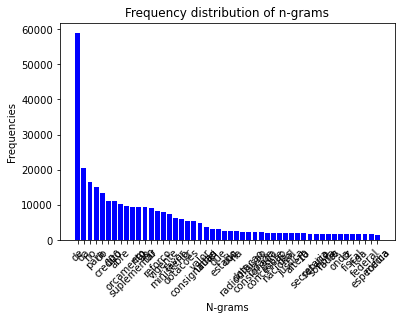

In [19]:
print('Frequência de distribuição das palavras: ')
ed.plot_frequency_distribution_of_ngrams(ementasClassificadas)

Frequência de distribuição das palavras: 


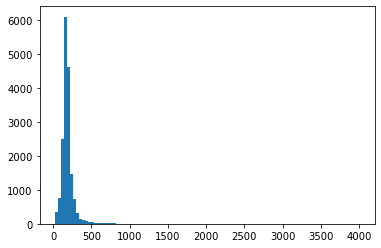

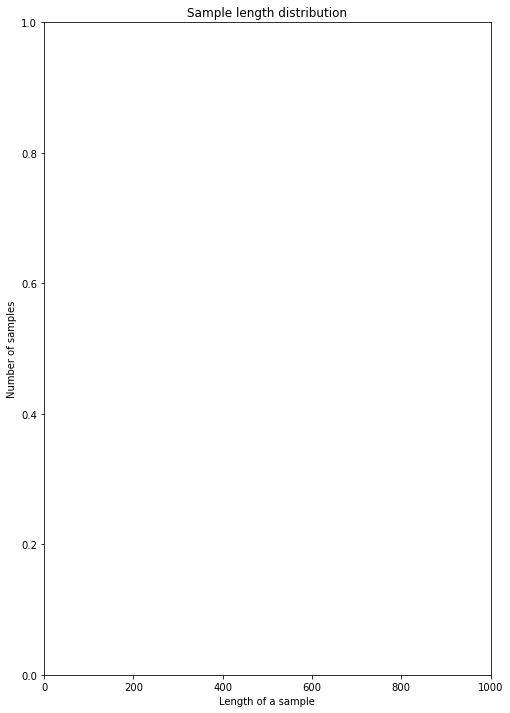

In [20]:
print('Frequência de distribuição das palavras: ')
ed.plot_sample_length_distribution(ementasClassificadas)

Distribuição das classes:

## Definição do modelo

Verificação da definição do modelo. Segundo o tutorial, se a razão do número de amostras pelo número de palavras por amostra for menor que 1500, a utilização de n-grams é recomendada (https://developers.google.com/machine-learning/guides/text-classification/step-2-5?hl=pt-br). 

In [21]:
# Cálculo da razão amostras / número de palavras
print('Número de amostras/ Número de palavras por amostra: ',numeroAmostras/numeroDePalavrasPorAmostra )

Número de amostras/ Número de palavras por amostra:  645.8518518518518


Continuaremos a análise utilizando a abordagem de n-grams então.

# Preparação das informações

Seguindo o tutorial, fazemos a normalização de n-grams, tokenizando as palavras, aplicando o TF-IDF  e selecionando apenas as maiores 20 mil features

In [22]:
import tensorflow as tf
from tensorflow import keras
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif



In [34]:
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500

def get_tfidf_vectorizer():
 # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY
    }
    return TfidfVectorizer(**kwargs)


def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as ngram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of uni-grams + bi-grams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
   
    vectorizer = get_tfidf_vectorizer()
    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts).todense()

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts).todense()

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train)
    x_val = selector.transform(x_val)

    x_train = x_train.astype('float32')
    x_val = x_val.astype('float32')
    return x_train, x_val

# Construção do modelo

O tutorial recomenda o uso de MLP para a classificação, afirmando que ele performou melhor

In [31]:
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
import build_model
import explore_data

FLAGS = None


def train_ngram_model(train_texts, 
                        train_labels,
                        val_texts,
                         val_labels,
                        classeTreinamento,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2
                      ):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.

    # Verify that validation labels are in the same range as training labels.
    num_classes = explore_data.get_num_classes(train_labels)
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(
                             unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val = ngram_vectorize(
        train_texts, train_labels, val_texts)

    # Create model instance.
    model = build_model.mlp_model(layers=layers,
                                  units=units,
                                  dropout_rate=dropout_rate,
                                  input_shape=x_train.shape[1:],
                                  num_classes=num_classes)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    # optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    
    model.compile(optimizer='adam', loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    nomeArquivoModelo = classeTreinamento + '_mlp_model.h5'
    model.save(nomeArquivoModelo)
    
    return nomeArquivoModelo


Definiremos os datasets de treino e testes:

In [35]:
X = ementasClassificadas
y = leis_classificadas[MARKER_COLUMN_NAME]

train_data, val_data, train_labels, val_labels = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

nomeArquivoModelo = train_ngram_model(train_labels=train_labels.to_numpy(), 
train_texts=train_data.to_numpy(), val_labels = val_labels.to_numpy(), val_texts= val_data.to_numpy(), classeTreinamento=CLASSE_TREINAMENTO)




C:\Users\demet\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_extraction\text.py:2008: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(
C:\Users\demet\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:723: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\demet\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:723: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\demet\AppData\Roaming\Pytho

Epoch 1/1000
96/96 - 15s - loss: 0.2907 - acc: 0.9871 - val_loss: 0.0719 - val_acc: 0.9950
Epoch 2/1000
96/96 - 6s - loss: 0.0476 - acc: 0.9951 - val_loss: 0.0308 - val_acc: 0.9950
Epoch 3/1000
96/96 - 6s - loss: 0.0273 - acc: 0.9951 - val_loss: 0.0239 - val_acc: 0.9950
Epoch 4/1000
96/96 - 6s - loss: 0.0211 - acc: 0.9951 - val_loss: 0.0211 - val_acc: 0.9950
Epoch 5/1000
96/96 - 6s - loss: 0.0175 - acc: 0.9951 - val_loss: 0.0193 - val_acc: 0.9950
Epoch 6/1000
96/96 - 7s - loss: 0.0138 - acc: 0.9952 - val_loss: 0.0178 - val_acc: 0.9950
Epoch 7/1000
96/96 - 6s - loss: 0.0115 - acc: 0.9955 - val_loss: 0.0166 - val_acc: 0.9952
Epoch 8/1000
96/96 - 6s - loss: 0.0092 - acc: 0.9962 - val_loss: 0.0157 - val_acc: 0.9956
Epoch 9/1000
96/96 - 6s - loss: 0.0068 - acc: 0.9974 - val_loss: 0.0151 - val_acc: 0.9956
Epoch 10/1000
96/96 - 8s - loss: 0.0061 - acc: 0.9981 - val_loss: 0.0149 - val_acc: 0.9956
Epoch 11/1000
96/96 - 6s - loss: 0.0050 - acc: 0.9984 - val_loss: 0.0149 - val_acc: 0.9954
Epoch 1

In [38]:
from keras.models import load_model
texto = np.array(['Estabelece medidas para proteção das florestas existentes nas nascentes dos rios e dá outras providências.','Cria um Horto Florestal no Município de Silvânia, no Estado de Goiás.', 'Dispõe sôbre os incentivos fiscais concedidos a empreendimentos florestais.'])
nomeArquivoModelo = 'Meio Ambiente_mlp_model.h5'
model = load_model(nomeArquivoModelo)
# vectorizer = get_tfidf_vectorizer()
# textoTeste = vectorizer.fit_transform(texto).todense()
result = model.predict(texto)
result

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 20000)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                1280064   
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


ValueError: in user code:

    File "c:\Users\demet\anaconda3\envs\mdenv\lib\site-packages\keras\engine\training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\demet\anaconda3\envs\mdenv\lib\site-packages\keras\engine\training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\demet\anaconda3\envs\mdenv\lib\site-packages\keras\engine\training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\demet\anaconda3\envs\mdenv\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
        return self(x, training=False)
    File "c:\Users\demet\anaconda3\envs\mdenv\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\demet\anaconda3\envs\mdenv\lib\site-packages\keras\engine\input_spec.py", line 228, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_2" (type Sequential).
    
    Input 0 of layer "dense_4" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer "sequential_2" (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=string)
      • training=False
      • mask=None
